# E-Commerce Product Recommender System

**Context:**
Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

**Data Description:**
First three columns are userId, productId, and ratings and the fourth column is timestamp. 

**Source** - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) 

The repository has several datasets. For this case study, I am using the Electronics dataset.

**Objective** - Build Popularity based and Collaborative recommender systems. 

In [335]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
from  sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.sparse.linalg import svds
from surprise import SVD, accuracy
from surprise import Reader, Dataset
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the data set and add columns

df1 = pd.read_csv('ratings_Electronics.csv')

In [3]:
#Fetches top 5 rows
df1.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
df1.columns = ['UserId', 'ProductId', 'Ratings', 'Timestamp']

In [5]:
# Drop the timestamp column
df1.drop('Timestamp',axis=1,inplace=True)

In [6]:
df1.head()

,UserId,ProductId,Ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


    Timestamp column has been removed.

In [7]:
df1.shape

(7824481, 3)

    Dataset contains 7824482 rows and 3 columns

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
UserId       object
ProductId    object
Ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


    Datatypes of UserId, ProductId and Ratings are object, object and float respectively

In [9]:
# Check whether identical rows are present

dups = df1[df1.duplicated()]
dups

,UserId,ProductId,Ratings


    Duplicate rows are not present. 

In [10]:
# five point summary

df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


    * 5 point summary looks reasonable.
    * Minimum rating present in the dataset is 1.
    * Maximum rating present in the dataset is 5.
    * Average rating present in the dataset is 4.
    * Median is 5, which means more than 50% of products have 5 rating.

In [352]:
# Check for missing values present
print('Number of missing values -\n\n', df1.isnull().sum())
print('\nNumber of NaN values -\n\n', df1.isna().sum())

Number of missing values -

 UserId       0
ProductId    0
Ratings      0
dtype: int64

Number of NaN values -

 UserId       0
ProductId    0
Ratings      0
dtype: int64


    Missing values and NaN are not present in the dataset.

In [12]:
df1["Ratings"].value_counts()

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Ratings, dtype: int64

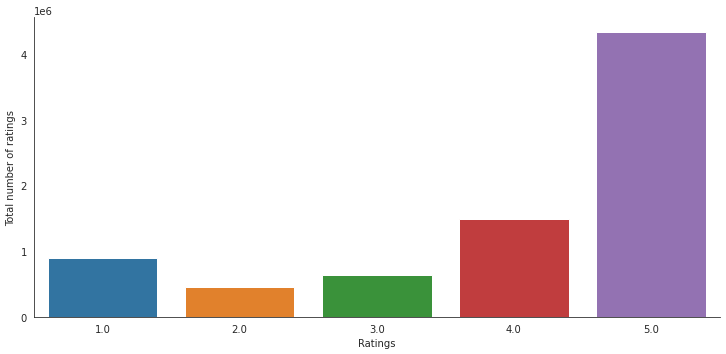

In [13]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data=df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

    1e6 denotes 6 zeroes after the each value in y-axis. Since the count is large, y-axis range has been mentioned as 1e6.

In [14]:
df1["Ratings"].value_counts()

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Ratings, dtype: int64

As seen above, most of the products have rating 5. More of products have rating 4 as well.

In [15]:
# Number of ratings, unique user id and product id in the data
print("\nTotal no of Ratings :",df1.shape[0])
print("Total No of Users   :", len(np.unique(df1.UserId)))
print("Total No of products :", len(np.unique(df1.ProductId)))


Total no of Ratings : 7824481
Total No of Users   : 4201696
Total No of products : 476001


In [16]:
# Identify number of ratings provided by users
user_grouped = df1.groupby('UserId').size().sort_values(ascending=False)

In [17]:
user_grouped.head()

UserId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
dtype: int64

In [18]:
print("Out of Total {} Users, {} Users provided ratings for 1 Product" 
      .format(user_grouped.count(), user_grouped[user_grouped == 1].count()))

Out of Total 4201696 Users, 2881833 Users provided ratings for 1 Product


### Create Subset of Dataset to make it less sparse/ denser

In [19]:
print("Out of Total {} Users, {} Users provided ratings for 50 or more Products" 
      .format(user_grouped.count(), user_grouped[user_grouped >= 50].count()))

Out of Total 4201696 Users, 1540 Users provided ratings for 50 or more Products


In [20]:
#users who gave 50 and more ratings are considered
df_50 = df1[df1['UserId'].isin(user_grouped[user_grouped >= 50].index)] 

In [21]:
df_50.shape

(125871, 3)

    Original dataset has 7824481 rows whereas after filtering with 50 or more users the dataset has 125871 rows.  

In [22]:
df_50.sort_values(by='UserId').head()

,UserId,ProductId,Ratings
482449,A100UD67AHFODS,B0002KVQBA,5.0
4028734,A100UD67AHFODS,B004CQMXDA,5.0
7173278,A100UD67AHFODS,B00BUACE8K,5.0
5664237,A100UD67AHFODS,B0077YTFPS,5.0
1339197,A100UD67AHFODS,B000RYS3S0,3.0


In [23]:
print("Total number of unique Users in subset dataframe    : ", df_50["UserId"].nunique())
print("Total number of unique Products in subset dataframe : ", df_50["ProductId"].nunique())

Total number of unique Users in subset dataframe    :  1540
Total number of unique Products in subset dataframe :  48190


## Popularity Based Recommendation

Popularity Based Recommendation system works by recommending items that are viewed and purchased by most people, and/or are rated high. It is not a personalized recommendation.

Popularity based recommender system is built on full dataset. Multiple users who have given single rating could have bought the same product. Therefore, users with single ratings are also considered for Popularity based recommender system.

### *First scenario - Build Popularity based recommendation based on highest number of Purchases. In this scenario, rating is NOT considered.*

In [24]:
product_grouped = df1.groupby('ProductId').size().sort_values(ascending=False)

In [25]:
product_grouped.describe()

count    476001.000000
mean         16.437951
std         112.702749
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
dtype: float64

    * Total number of unique products 476002 in the dataset.
    * 25% of products were rated by 1 user.
    * Maximum number of ratings provided to a product is 18244.
    * 75% of products were rated by less than 7 users.  

In [26]:
print("Number of products rated by single user             : ", product_grouped[product_grouped == 1].count())
print("Number of products rated by less than 10 users      : ", product_grouped[product_grouped <= 10].count())
print("Number of products rated by less than 500 users     : ", product_grouped[product_grouped <= 500].count())
print("Number of products rated by less than 1000 users    : ", product_grouped[product_grouped <= 1000].count())
print("Number of products rated by greater than 1000 users : ", product_grouped[product_grouped > 1000].count())

Number of products rated by single user             :  179737
Number of products rated by less than 10 users      :  385104
Number of products rated by less than 500 users     :  474131
Number of products rated by less than 1000 users    :  475336
Number of products rated by greater than 1000 users :  665


**Out of 476002 products, only 665 products were rated by more than 1000 users.**

Text(0, 0.5, 'Number of Purchases')

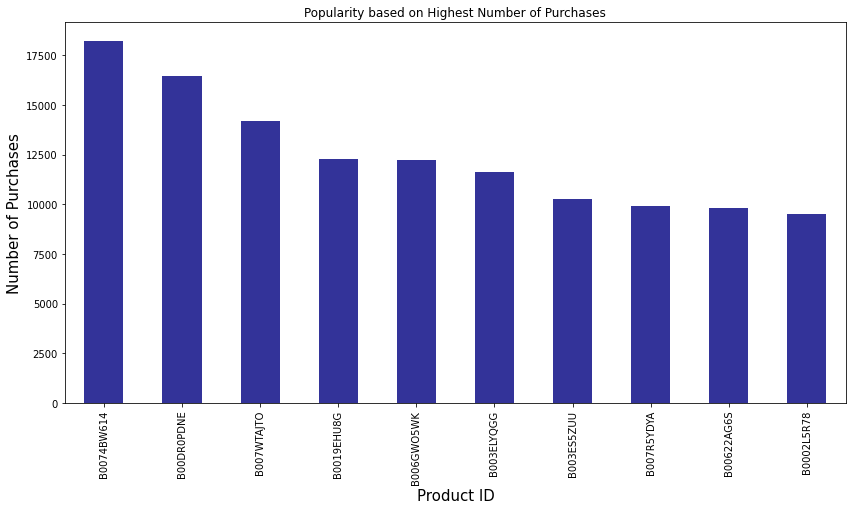

In [27]:
ax2 = product_grouped.nlargest(10).plot(kind='bar',figsize = (14,7),colormap='terrain',
                                 title="Popularity based on Highest Number of Purchases")
ax2.set_xlabel("Product ID", fontsize=15)
ax2.set_ylabel("Number of Purchases", fontsize=15)

**Bar chart shows the 10 Product ID's which have the highest number of purchases.**

### *Second scenario - Build Popularity based recommendation based on highest Rating (a product should be rated minimum by 500 users)*

In [28]:
product_grouped_t500 = df1.groupby('ProductId').filter(lambda x: x['ProductId'].count() >=500)

In [29]:
product_grouped_t500.nunique(axis=0)

UserId       1610755
ProductId       1874
Ratings            5
dtype: int64

    * Products which are rated by 500 and above users are considered.
    * As seen above, 1874 products were rated by more than 500 users.

In [30]:
# new dataframe to store products, ratings and number of ratings
product_grouped_t500_rt = pd.DataFrame(product_grouped_t500.groupby('ProductId')['Ratings'].mean())
product_grouped_t500_rt['Counts'] = pd.DataFrame(product_grouped_t500.groupby('ProductId')['Ratings'].count())

In [31]:
product_grouped_t500_rt.sort_values(by=['Ratings'],ascending=False).head()

,Ratings,Counts
ProductId,,
B0043WJRRS,4.881369,2512
B0029N3U8K,4.869301,658
B004Y1AYAC,4.854442,529
B003FVVMS0,4.853412,1876
B001W26TIW,4.843537,735


Text(0, 0.5, 'Ratings')

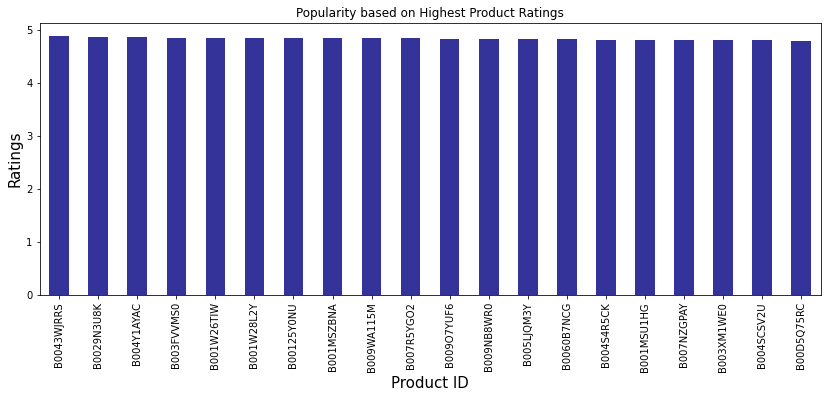

In [32]:
ax3 = product_grouped_t500_rt['Ratings'].nlargest(20).plot(kind='bar',figsize = (14,5),colormap='terrain',
                                 title="Popularity based on Highest Product Ratings")
ax3.set_xlabel("Product ID", fontsize=15)
ax3.set_ylabel("Ratings", fontsize=15)

    * Bar chart shows ratings of top 20 products are very close to each other.
    * In the products that are rated by more than 500 users, ProductID B0043WJRRS has the highest rating.

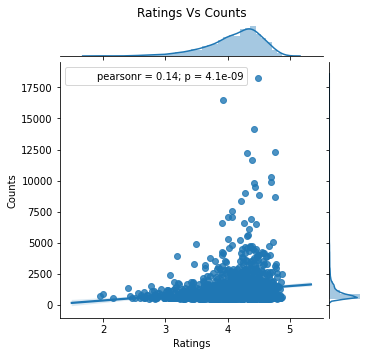

In [33]:
# Bivariate Analysis between Ratings and Counts

g = sns.jointplot(x='Ratings', y='Counts', data=product_grouped_t500_rt, kind='reg',ratio = 7,
                  height=5).annotate(stats.pearsonr)
g.fig.suptitle("Ratings Vs Counts") 
g.fig.subplots_adjust(top=0.93)
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.show()

    * In most cases, products which are rated by less than 2500 users has the highest ratings.  

### Split the data into Train and Test

In [34]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_50,reader)

In [35]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=1)

In [36]:
trainset.ur

defaultdict(list,
            {0: [(0, 2.0),
              (69, 5.0),
              (545, 4.0),
              (2016, 1.0),
              (1558, 3.0),
              (2592, 5.0),
              (4175, 4.0),
              (4874, 5.0),
              (3758, 5.0),
              (8151, 4.0),
              (8737, 4.0),
              (8931, 5.0),
              (111, 4.0),
              (667, 5.0),
              (1207, 4.0),
              (8486, 4.0),
              (8973, 4.0),
              (8834, 4.0),
              (8225, 4.0),
              (17660, 4.0),
              (1278, 4.0),
              (1117, 4.0),
              (3619, 4.0),
              (9253, 2.0),
              (26021, 3.0),
              (7795, 2.0),
              (1069, 4.0),
              (27593, 5.0),
              (3228, 5.0),
              (7586, 4.0),
              (29337, 5.0),
              (30249, 4.0),
              (8146, 4.0),
              (2665, 4.0),
              (32744, 5.0),
              (32985, 4.0),
        

### *User Collaborative filtering by KNNWithMeans*

It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. It is a personalized recommendation.

In [339]:
# Defined a function to find the optimal neighbor
arr1 = []
arr2 = []
def knn_with_means(n):
    algo = KNNWithMeans(k=n, sim_options={'name': 'pearson_baseline', 'user_based': True})#'user_based': True denotes User Based Collaboration
    algo.fit(trainset)
    test_pred = algo.test(testset)
    RMSE = accuracy.rmse(test_pred, verbose=True)
    arr1.append(n)
    arr2.append(RMSE)
    return RMSE

In [340]:
# RMSE is calculated for different neighbors
cl = [10,20,30,40,50,60,70,80,90,100]

for i in cl:
    test_pred = []
    knn_with_means(i)

df_res1 = pd.DataFrame(arr1, columns=['neighbors'])
df_res1['RMSE'] = arr2

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0552
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0551
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done co

In [341]:
df_res1

,neighbors,RMSE
0,10,1.055238
1,20,1.055108
2,30,1.055103
3,40,1.055102
4,50,1.055102
5,60,1.055102
6,70,1.055102
7,80,1.055102
8,90,1.055102
9,100,1.055102


**As there is no difference in RMSE from 40 neighbors, optimal neighbors chosen as 40.**

Comparison of RMSE for different neighbors


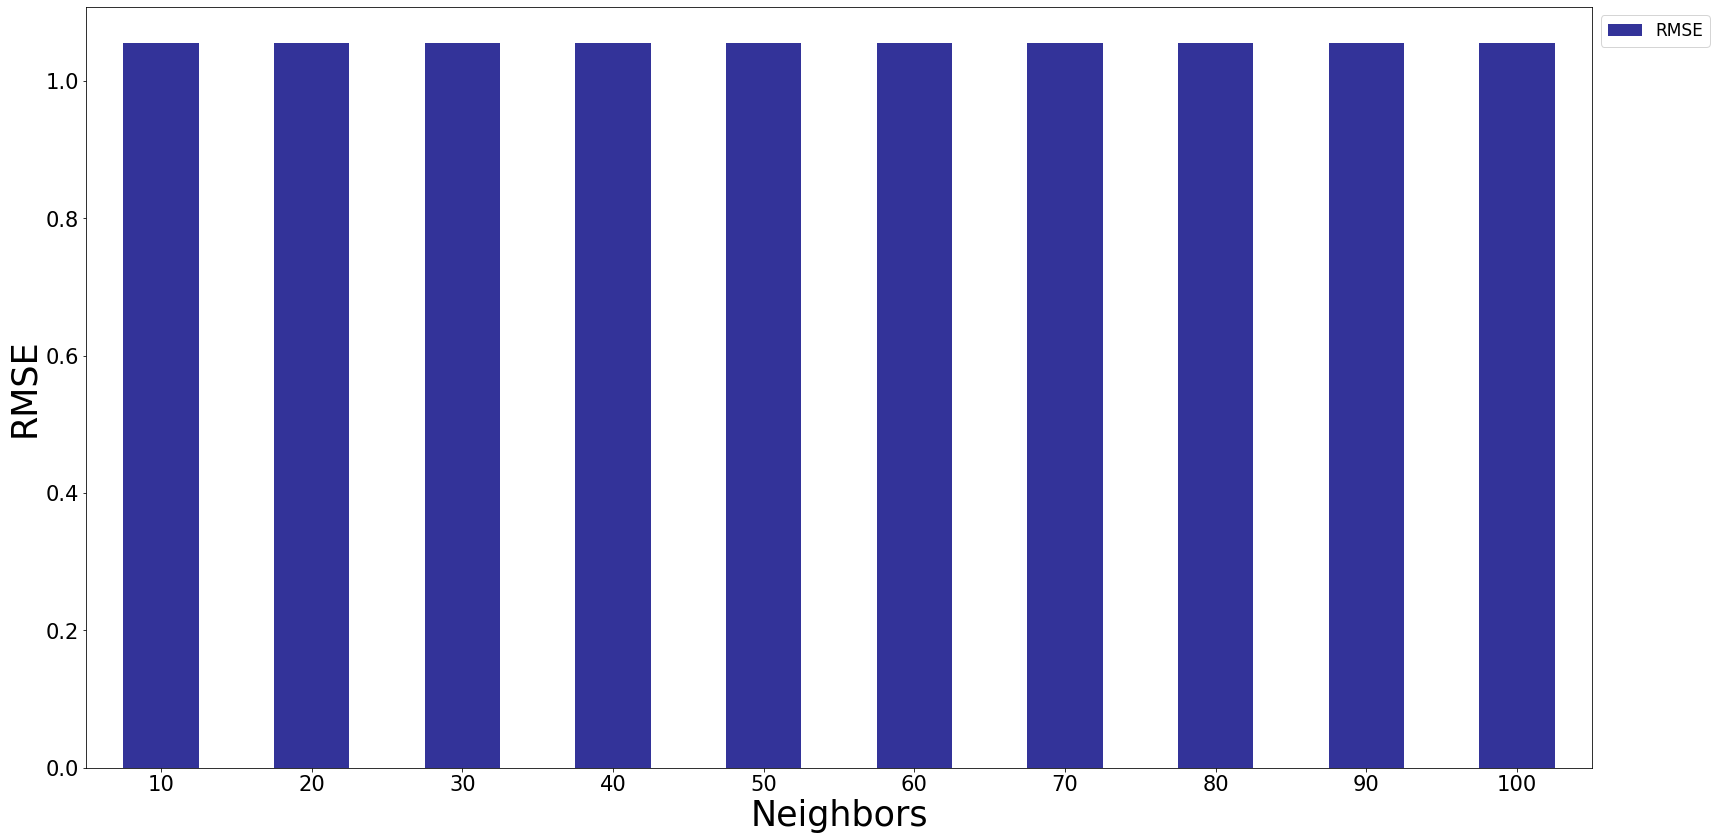

In [342]:
# Plot the bar chart
print("Comparison of RMSE for different neighbors")
ax = df_res1.plot(x='neighbors',y='RMSE',kind='bar', rot=0, figsize = (27,14), fontsize = 21,colormap='terrain') 
ax.legend(bbox_to_anchor=(1, 1), prop={'size': 17})
ax.set_ylabel("RMSE", fontsize=35)
ax.set_xlabel("Neighbors", fontsize=35)
plt.show()

Since the difference in RMSE is very small, difference in bar chart is not clearly visible. 

In [343]:
# predict recommendations based on 40 neighbors
algo = KNNWithMeans(k=40, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


    * k value denotes the maximum number of neighbors(users) to be considered.
    * pearson_baseline distance measure is used to calculate the distance between users
    * user_based "True" denotes User-User collaborating model

In [344]:
test_pred

[Prediction(uid='A3PDWA32BAMB2Y', iid='B00CGW74YU', r_ui=5.0, est=4.385964912280702, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A31BD4RXCON7QO', iid='B000P6G7YW', r_ui=1.0, est=4.259735100841004, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3J8A5L5AF5TX9', iid='B001GS8G06', r_ui=1.0, est=3.935483870967742, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A3D6OI36USYOU1', iid='B000A1790S', r_ui=5.0, est=4.259735100841004, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3JU16JTNLVK1J', iid='B002CX16WO', r_ui=2.0, est=4.259735100841004, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1ZU55TM45Y2R8', iid='B00HFAEBWG', r_ui=3.0, est=3.095333878188614, details={'actual_k': 13, 'was_impossible': False}),
 Prediction(uid='AYP0YPLSP9ISM', iid='B006Z0Q2SI', r_ui=3.0, est=3.55, details={'actual_k': 0, 'was_impossib

**Predictions are made for all the users**

In [345]:
# Function to return top-5 recommendations for each user.  

def get_top_n(predictions, n=5):
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in test_pred:
        top_n[uid].append((iid, est))
        
 # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [346]:
get_top_n(test_pred)

defaultdict(list,
            {'A3PDWA32BAMB2Y': [('B004W2JKWG', 4.87994081589516),
              ('B00CGW74YU', 4.385964912280702),
              ('B000Q8UAWY', 4.385964912280702),
              ('B003TXZCYE', 4.385964912280702),
              ('B008DW95NA', 4.385964912280702)],
             'A31BD4RXCON7QO': [('B000FVGM38', 4.932154545010502),
              ('B000P6G7YW', 4.259735100841004),
              ('B00000JX3C', 4.259735100841004),
              ('B000GC2DDE', 4.259735100841004),
              ('B001P817YY', 4.259735100841004)],
             'A3J8A5L5AF5TX9': [('B003LZ6F8M', 5),
              ('B005S0BYQ6', 4.745610453246223),
              ('B002G1YNQS', 4.54013503375844),
              ('B001W28L2Y', 4.536620311532298),
              ('B007BJHETS', 4.512038718455605)],
             'A3D6OI36USYOU1': [('B0009ST7DY', 5),
              ('B003ES5ZUU', 4.6343526350032525),
              ('B0038M3YM8', 4.275862068965517),
              ('B0035ERKYW', 4.275862068965517),
         

**Top 5 recommendations are made for all the users.**

In [347]:
# Function to return recommendation for specific user
def recommendations(predictions, usr):
    for uid, iid, true_r, est, _ in test_pred:
        if uid == usr:
            aiid.append(iid)
            aest.append(est)
         
    return aiid, aest

In [348]:
aiid = []
aest = []

usr = 'A31BD4RXCON7QO' # UserId for which recommendation is going to be returned
recommendations(test_pred,usr)

df_res2 = pd.DataFrame(aiid, columns=['Product Id'])
df_res2['Rating'] = aest
df_res2.sort_values(by='Rating',ascending=False,inplace=True)
df_res2.drop("Rating", axis=1,inplace=True)  
df_res2.set_index('Product Id',inplace=True)  
print("Recommendation for UserId : ", usr)
df_res2[0:5]

Recommendation for UserId :  A31BD4RXCON7QO


""
Product Id
B000FVGM38
B001943RYC
B005CMDOSQ
B001UITT6W
B00009XVBU


    These are the top 5 products recommended to User A31BD4RXCON7QO

In [349]:
print('\nRMSE of KNNWithMeans Model = {} \n'.format(accuracy.rmse(test_pred, verbose=True)))
print('\nMAE of KNNWithMeans Model  = {} \n'.format(accuracy.mae(test_pred, verbose=True)))

RMSE: 1.0551

RMSE of KNNWithMeans Model = 1.0551024899101666 

MAE:  0.7777

MAE of KNNWithMeans Model  = 0.7776553537002212 



### *User Collaborative filtering by SVDS*

In [242]:
# creates a pivot table with row per 'user' and column per 'product' 
pivot_df_t = df_50.pivot(index = 'UserId', columns ='ProductId', values = 'Ratings').fillna(0)
pivot_df_t.shape
pivot_df_t.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
final_ratings_matrix = df_50.pivot(index = 'UserId', columns ='ProductId', values = 'Ratings').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings) # beacuse 0 is NA

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1] # will include 0's 
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [244]:
# creates a index from 0 to total number of rows for easy handling in further steps
pivot_df_t['User_Index'] = np.arange(0, pivot_df.shape[0],1)

In [320]:
pivot_df = pivot_df_t.copy() #further modifications are going to performed in pivot_df
df_t2 = pivot_df_t['User_Index']

In [321]:
df_t2[11:12] # test to retreive a particular userid using user_index

UserId
A10ZBR6O8S8OCY    11
Name: User_Index, dtype: object

In [248]:
# User_Index is set a new index
pivot_df.set_index(['User_Index'], inplace=True)
pivot_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User_Index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
# Loop to check the optimal k value for SVD
cl2 = [5,7,9,11,12,14]
svd_a = []
svd_rmse = []
for a in cl2: 
    rmse_df = pd.DataFrame()
    U, sigma, Vt = svds(pivot_df, k = a) # SVD built for each k value from the array  
    sigma = np.diag(sigma) # creates sigma diagonal matrix 
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt -> predict the ratings 
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns) #loads the predicted ratings in a df
    rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
    rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
    rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1) 
    svd_rmse.append((mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))**0.5)
    svd_a.append(a)

In [250]:
df_resa = pd.DataFrame(svd_a, columns=['K-Value'])
df_resa['RMSE'] = svd_rmse
df_resa

,K-Value,RMSE
0,5,0.003573
1,7,0.003433
2,9,0.003348
3,11,0.003277
4,12,0.003276
5,14,0.003267


**There is no significant improvement in k value from 11. Therefore, optimal K value is 11.**

In [251]:
# Singular Value Decomposition with k value 11
U, sigma, Vt = svds(pivot_df, k = 11) 
sigma = np.diag(sigma) 

    * U has the left singular vectors (eigen vectors).
    * Sigma has singular values (eigen values) and is diagonal.
    * Vt has rows that are the right singular vectors (expression level vectors).

In [252]:
U.shape, sigma.shape, Vt.shape

((1540, 11), (11, 11), (11, 48190))

    * Shape has 1540 X 11 -> where 1540 is the number of rows, 11 is the concept(k) value.
    * Sigma has 11 X 11 -> where 11 is the concept(k) value.
    * Vt has 11 X 48190 -> where 11 is the concept(k) value., 48190 is the number of columns

In [253]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) # A = U.simga.Vt -> predicts the ratings for k value 11
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns) # predicted ratings are stored in preds_df
preds_df.head()

ProductId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002402,0.003674,-0.000135,0.009078,0.003871,0.002224,0.007395,0.001003,0.016681,0.002047,...,0.000594,0.047243,0.003935,0.064562,-0.001871,0.006908,0.001650,0.120222,0.068419,0.017937
1,0.001841,0.002664,-0.001662,0.020045,0.006965,0.000060,0.015878,0.001042,-0.000053,0.000116,...,0.000176,0.034117,0.001661,0.007091,-0.002679,-0.000366,0.004612,-0.056668,0.008016,0.008445
2,-0.001506,-0.002538,0.003700,0.015957,0.006751,-0.001806,0.005222,0.003339,-0.005840,-0.001349,...,-0.000318,0.008088,-0.002827,-0.018447,0.019840,-0.002540,-0.000201,0.000992,-0.014842,-0.005583
3,0.002724,0.003869,0.001679,0.009457,0.004072,0.002754,0.003553,0.000108,0.008048,0.002362,...,0.000603,-0.003283,0.003462,-0.003308,-0.000742,0.000124,0.002615,-0.015414,-0.006478,0.003360
4,0.000551,0.000143,-0.000427,0.010950,0.004381,-0.000168,0.006947,0.001314,0.000990,-0.000019,...,-0.000010,0.000648,0.000279,-0.022718,0.004858,-0.002077,0.001337,-0.054908,-0.010866,-0.001646


In [322]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False) #user_idx is the row number
    # Sort the predicted user ratings 
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1) #merge actual and predicted ratings
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   # filtering users who have given no ratings
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the Recommended Items for {} \n'.format(df_t2[userID:userID+1]))
    print(temp.head(num_recommendations)) 

In [324]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 14
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the Recommended Items for UserId
A110VKXAVLAYKY    14
Name: User_Index, dtype: object 

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.415614
B003ES5ZUU                  0.0          0.361126
B002V88HFE                  0.0          0.265085
B005HMKKH4                  0.0          0.216545
B002WE6D44                  0.0          0.200274


**Above 5 products are recommended for user A110VKXAVLAYKY. The model provides 5 recommended items for input user id.**

In [336]:
svd_rmse_f = sqrt(mean_squared_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings))
print('\nRMSE of SVD Model = {} \n'.format(svd_rmse_f))

svd_mae_f = mean_absolute_error(rmse_df.Avg_actual_ratings, rmse_df.Avg_predicted_ratings)
print('\nMAE of SVD Model  = {} \n'.format(svd_mae_f))


RMSE of SVD Model = 0.0032766904463390565 


MAE of SVD Model  = 0.002234087000789304 



**Impressive RMSE and MAE by SVD model.**

## Conclusion

The assignment is to 
    - Recommend most popular products to users through Popularity Recommender system. 
    
    - Recommend five new products to users based on their habits through Collaborative Filtering Recommender system.
    
**Points to consider -** 

1) Electronics Rating dataset is huge, it has 7824481 rows. 

    a) For Popularity recommender system, all the rows were passed as input.

    b) For Collaborative recommender system, users with 50 or above ratings were considered.
    
2) Two types of Popularity Recommender system has been built -

    a) One based on highest number of Purchases. In this scenario, rating is NOT considered.
    
    b) Another based on highest Rating (a product should be rated minimum by 500 users)

3) Two methods of User Collaborative Recommender system has been built -

    a) KNNWithMeans - Model has been built with Optimal neighbors. RMSE and MAE metric's are 1.055102 and 0.777655 
    respectively.
    
    b) SVD - Model has been built with Optimal vectors. RMSE and MAE metric's are 0.0032767 and 0.00223408 respectively.

**Final Words -**

    Popularity Based recommender system has been built successfully. 
    
    Collaborative recommender system has been built through KNNWithMeans and SVD. Both these models performed well on 
    this large dataset. With respect to model performance, SVD performed exceptionally well.